In [1]:
%matplotlib inline
import timeit
import matplotlib.pylab as plt
import numpy as np
from numba import jit, njit, cuda, prange, uint16, int32
import math
import random
from tqdm.notebook import tqdm

plt.style.use('ggplot')

Le programme étant basé sur le jeu de la vie on reprend les mêmes fonctions utilitaires

In [2]:
def constructions(X,Y,T):
    monde = np.zeros((T,X,Y), dtype=np.uint16)    
    return monde

def initialiser(monde, seuil=0.25):
    monde[0,:,:] = (np.random.rand(monde.shape[1],monde.shape[2])>seuil)*1


L'évolution du monde est calculée par Numba pour prendre le moins de temps possible.

In [3]:
@cuda.jit
def kernel_cuda_device_shared(d_monde, t):    
    tmp_array = cuda.shared.array(shape=(32+1+1, 32+1+1), dtype=uint16)
    
    x, y = cuda.grid(2)         
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    _, n, m = d_monde.shape
        
    # Remplissage de la mémoire partagée
    if 0 <= x < n and 0 <= y < m : 
        
        tmp_array[tx+1, ty+1] = d_monde[t-1,x,y]
                
        # Colonne de gauche
        if tx==0 and (x-1)>=0:
            tmp_array[tx, ty+1] = d_monde[t-1,x-1,y]        
        # Colonne de droite
        if tx==cuda.blockDim.x-1 and (x+1)<n:
            tmp_array[tx+2, ty+1] = d_monde[t-1,x+1,y] 

        # Ligne supérieure
        if ty==0 and y>0:
            tmp_array[tx+1, 0] = d_monde[t-1,x,y-1]
            # Coin gauche
            if tx==0 and x>0:
                tmp_array[tx, ty] = d_monde[t-1,x-1,y-1]
           # Coin droit
            if tx==cuda.blockDim.x-1 and (x+1)<n:
                tmp_array[tx+2, ty] = d_monde[t-1,x+1,y-1]
        
        # Ligne inférieure
        if ty==cuda.blockDim.y-1 and (y+1)<m:
            tmp_array[tx+1, ty+2] = d_monde[t-1,x,y+1]
            # Coin gauche
            if tx==0 and x>0:
                tmp_array[tx, ty+2] = d_monde[t-1,x-1,y+1]
            # Coin droit
            if tx==cuda.blockDim.x-1 and (x+1)<n:
                tmp_array[tx+2, ty+2] = d_monde[t-1,x+1,y+1]
          
        cuda.syncthreads()    

        # Mise à jour du voisinnage    
        somme = 0
        if tmp_array[tx,ty]>0:
            somme +=1
        if tmp_array[tx+1,ty]>0:
            somme +=1
        if tmp_array[tx+2,ty]>0:
            somme +=1

        if tmp_array[tx,ty+1]>0:
            somme +=1
        if tmp_array[tx+2,ty+1]>0:
            somme +=1

        if tmp_array[tx,ty+2]>0:
            somme +=1
        if tmp_array[tx+1,ty+2]>0:
            somme +=1
        if tmp_array[tx+2,ty+2]>0:
            somme +=1      

            
    if 1 <= x < (n-1) and 1 <= y < (m-1) :         
        if (somme==3) or (somme==4):
            d_monde[t,x,y] = tmp_array[tx+1, ty+1] + 1
        else:
            d_monde[t,x,y] = 0
   
        
def evoluer_numba_cuda_device_shared(monde):    
    threadsperblock = (32, 32)            
    blockspergrid_x = math.ceil(monde.shape[1] / threadsperblock[0])
    blockspergrid_y = math.ceil(monde.shape[2] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)   
    d_monde = cuda.to_device(monde)
    for t in range(1,monde.shape[0]):    
        kernel_cuda_device_shared[blockspergrid, threadsperblock](d_monde, t)
    d_monde.copy_to_host(monde)  

L'histogramme de référence est calculé sur le CPU avec Numba.

In [4]:
@njit(cache=True)
def calcul_histogramme_numba(monde, histogramme):
    for x in range(monde.shape[1]):
        for y in range(monde.shape[2]):   
            histogramme[monde[-1,x,y]] += 1            

L'implémentation "naïve" sur la carte graphique est une transposition de l'algorithme sur le CPU.

In [5]:
@cuda.jit
def kernel_cuda(monde, histogramme):    
    x, y = cuda.grid(2)            
    n, m = monde.shape
    if x < n and y < m :
        histogramme[monde[x,y]] += 1

        
def calcul_histogramme_cuda_naif(monde, histogramme):    
    threadsperblock = (32, 32)            
    blockspergrid_x = math.ceil(monde.shape[1] / threadsperblock[0])
    blockspergrid_y = math.ceil(monde.shape[2] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)    
    kernel_cuda[blockspergrid, threadsperblock](monde[-1,:,:], histogramme)

Les résultats par la fonction précédente sont faux car des conflits mémoire ont lieu. Il est nécessaire d'utiliser des opérations atomiques (qui évitent les conflits d'accès) pour obtenir le bon résultat.

In [6]:
@cuda.jit
def kernel_cuda_atomic(monde, histogramme):    
    x, y = cuda.grid(2)            
    n, m = monde.shape
    if x < n and y < m :
        cuda.atomic.add(histogramme, monde[x,y], 1)        

        
def calcul_histogramme_cuda_atomic(monde, histogramme):    
    threadsperblock = (32, 32)            
    blockspergrid_x = math.ceil(monde.shape[1] / threadsperblock[0])
    blockspergrid_y = math.ceil(monde.shape[2] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)    
    kernel_cuda_atomic[blockspergrid, threadsperblock](monde[-1,:,:], histogramme)

Les résultats sont maintenant corrects mais le programme est moins performant que sur la carte graphique. Comme précédement, la mémoire partagée va être utilisée pour miniser les accès à la mémoire globale.

In [7]:
@cuda.jit
def kernel_cuda_atomic_shared(monde, histogramme):    
    x, y = cuda.grid(2)            
    n, m = monde.shape
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    tmp_array = cuda.shared.array(shape=50, dtype=int32)
    # Copie
    pos = ty*cuda.blockDim.x + tx 
    if pos < tmp_array.shape[0]:
        tmp_array[pos] = 0
    
    cuda.syncthreads()    
        
    if x < n and y < m :
        cuda.atomic.add(tmp_array, monde[x,y], 1)        
    
    cuda.syncthreads()   
    
    if pos < tmp_array.shape[0]:
        cuda.atomic.add(histogramme, pos, tmp_array[pos])    
        
def calcul_histogramme_cuda_atomic_shared(monde, histogramme):
    threadsperblock = (32, 32)            
    blockspergrid_x = math.ceil(monde.shape[1] / threadsperblock[0])
    blockspergrid_y = math.ceil(monde.shape[2] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)    
    kernel_cuda_atomic_shared[blockspergrid, threadsperblock](monde[-1,:,:], histogramme)

500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750 2800 2850 2900 2950 3000 3050 3100 3150 3200 3250 3300 3350 3400 3450 3500 

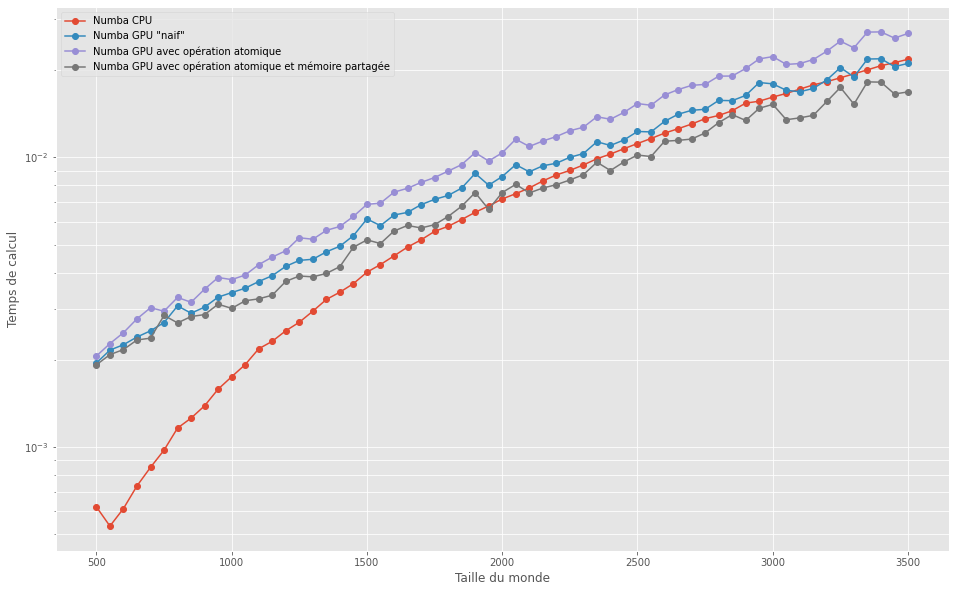

In [9]:
NB_REPET = 1000
tailles = range(500,3501,50)
GENERATION = 50

temps_cpu_calcul_histogramme_numba = np.zeros(len(tailles))
temps_gpu_calcul_histogramme_cuda_naif = np.zeros(len(tailles))
temps_gpu_calcul_histogramme_cuda_atomic = np.zeros(len(tailles))
temps_gpu_calcul_histogramme_cuda_atomic_shared = np.zeros(len(tailles))

for t in tailles:
        print(t, end=" ")    
        monde = constructions(t,t,GENERATION)
        initialiser(monde,0.25)
        evoluer_numba_cuda_device_shared(monde)
        
        histogramme_numba=np.zeros(GENERATION, dtype=np.int32)    
        histogramme_cuda_naif = np.zeros(GENERATION, dtype=np.int32)
        histogramme_cuda_atomic = np.zeros(GENERATION, dtype=np.int32)
        histogramme_cuda_atomic_shared = np.zeros(GENERATION, dtype=np.int32)       
        
        temps = timeit.timeit("calcul_histogramme_numba(monde, histogramme_numba)",  globals=globals(),  number=10)     
        temps_cpu_calcul_histogramme_numba[tailles.index(t)] = temps/10    
        
        temps = timeit.timeit("calcul_histogramme_cuda_naif(monde, histogramme_cuda_naif)",  globals=globals(),  number=NB_REPET)     
        temps_gpu_calcul_histogramme_cuda_naif[tailles.index(t)] = temps/NB_REPET    
        
        temps = timeit.timeit("calcul_histogramme_cuda_atomic(monde, histogramme_cuda_atomic)",  globals=globals(),  number=NB_REPET)     
        temps_gpu_calcul_histogramme_cuda_atomic[tailles.index(t)] = temps/NB_REPET   
        
        temps = timeit.timeit("calcul_histogramme_cuda_atomic_shared(monde, histogramme_cuda_atomic_shared)",  globals=globals(),  number=NB_REPET)     
        temps_gpu_calcul_histogramme_cuda_atomic_shared[tailles.index(t)] = temps/NB_REPET 
        
plt.figure(figsize=(16,10))    
plt.semilogy(tailles,temps_cpu_calcul_histogramme_numba, marker="o")
plt.semilogy(tailles,temps_gpu_calcul_histogramme_cuda_naif, marker="o")
plt.semilogy(tailles,temps_gpu_calcul_histogramme_cuda_atomic, marker="o")
plt.semilogy(tailles,temps_gpu_calcul_histogramme_cuda_atomic_shared, marker="o")
plt.legend(("Numba CPU","Numba GPU \"naif\"","Numba GPU avec opération atomique","Numba GPU avec opération atomique et mémoire partagée"))
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.ylabel("Temps de calcul")
plt.xlabel("Taille du monde")
plt.show()   

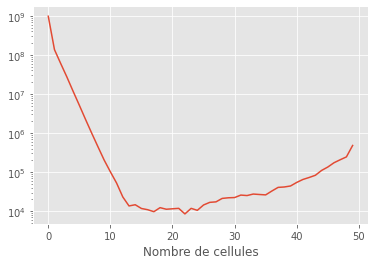

In [27]:
monde = constructions(1000,1000,50)
initialiser(monde,0.25)
evoluer_numba_cuda_device_shared(monde)
histogramme_cuda_atomic_shared = np.zeros(GENERATION, dtype=np.int32)  
calcul_histogramme_cuda_atomic_shared(monde, histogramme_cuda_atomic_shared)


plt.figure(figsize=(16,10))    
plt.semilogy(range(GENERATION),histogramme_cuda_atomic_shared)
plt.xlabel("Age (en générations)")
plt.ylabel("Nombre de cellules")
plt.show()